# Import 

In [1]:
import keras
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from keras.applications import  VGG16
from keras.models import Sequential
from keras import losses
from keras_tqdm import TQDMNotebookCallback, TQDMCallback
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
from keras_tqdm import TQDMCallback
from keras.utils import np_utils
from cat_dogs_dataset import GetDataGenerators,GetRawDataGenerators
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from TreatData import *

np.random.seed(1675)  # for reproducibility

/root/miniconda3/envs/objdetect/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Choose the transfer learning layers 

In [4]:
LastLayer = 10  # Last transfer learning layer number. Check the summary to make the appropriate choice.

batch_size=16
steps = CalculateSteps("DatasetJPG",batch_size)

vgg16_model = VGG16(weights="vgg16_weights_tf_dim_ordering_tf_kernels.h5", include_top=True)
print('\n')
print('All Layers:')


for i, layer in enumerate(vgg16_model.layers):
    print(i , layer.name, layer.output_shape)
    
feature_layers = vgg16_model.layers[:(LastLayer+1)]
bottleneckModel =  Sequential(feature_layers)
print('\n')
print('Frozen Layers:')


for i, layer in enumerate(bottleneckModel.layers):
    print(i , layer.name, layer.output_shape)



All Layers:
0 input_1 (None, 224, 224, 3)
1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
3 block1_pool (None, 112, 112, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
6 block2_pool (None, 56, 56, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
10 block3_pool (None, 28, 28, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
14 block4_pool (None, 14, 14, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)
18 block5_pool (None, 7, 7, 512)
19 flatten (None, 25088)
20 fc1 (None, 4096)
21 fc2 (None, 4096)
22 predictions (None, 1000)


Frozen Layers:
0 input_1 (None, 224, 224, 3)
1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
3 block1_pool (None, 112, 112, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 1

In [5]:
datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
# DatasetNorm
generator = datagen.flow_from_directory("DatasetJPG", 
                                        target_size=(224, 224), 
                                        batch_size=batch_size, 
                                        shuffle=True,
                                        class_mode='sparse')

Found 1303 images belonging to 4 classes.


In [6]:
totalfeatures = []
totaltargets = []
for i in range(steps):
    X, y = generator.next()
    features = bottleneckModel.predict(X)
    totalfeatures.append(features)
    totaltargets.append(y.reshape((-1,)))    
    
totalfeatures = np.vstack(totalfeatures)
totaltargets = np.vstack(totaltargets)

print("features shape:" + str(totalfeatures.shape))
print("output shape:" + str(totaltargets.shape))

features shape:(1296, 28, 28, 256)
output shape:(81, 16)


In [7]:
lr = 0.00001
epochs = 100
IS_NOTEBOOK = True
callbacks = [TQDMNotebookCallback()] if IS_NOTEBOOK else [TQDMCallback()]

# Train the CNN Model

In [ ]:

seed = 9
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

result = []
history_list = []

org_shape = totalfeatures.shape

Xflat = totalfeatures.reshape((org_shape[0], -1))
yflat = totaltargets.reshape(-1)

X = totalfeatures
y = keras.utils.to_categorical(yflat, num_classes=4)

for train, test in kfold.split(X , yflat):
    
    fc_layers = [
        Conv2D(512, kernel_size=(2, 2), activation='relu', padding='same', input_shape=org_shape[1:]),#, input_shape=bottleneck_features_train.data.shape[1:]),
        Conv2D(512, kernel_size=(2, 2), activation='relu', padding='same'),
        Conv2D(512, kernel_size=(2, 2), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Conv2D(512, kernel_size=(2, 2), activation='relu', padding='same'),
        Conv2D(512, kernel_size=(2, 2), activation='relu', padding='same'),
        Conv2D(512, kernel_size=(2, 2), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),

        Flatten(input_shape=org_shape[1:]),
        Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
        #Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01)),  ## adicionei para FL-10
        Dense(4, activation="softmax")]

    model = Sequential(fc_layers)
    model.summary()

    model.compile(loss=losses.categorical_crossentropy,
                          optimizer=keras.optimizers.Adam(lr=lr),
                          metrics=['accuracy'])

    history = model.fit(X[train], y[train],
                batch_size = batch_size,
                epochs=epochs,
                verbose=0,
                validation_data=(X[test], y[test]),
                callbacks=callbacks)
    
    score, acc = model.evaluate(X[test], y[test], verbose=0)
    print("Test score: %.3f, accuracy: %.3f" % (score,acc))
    result.append((score, acc))
    history_list.append(history)

# SAVE MODEL

In [12]:
SaveModelName = "modelSA_" + str(LastLayer) + ".h5"
#SaveModelName = "model_" + str(LastLayer) + ".h5"
SaveModelName_Json = SaveModelName.replace(".h5",'.json')

if os.path.isfile(SaveModelName) and os.path.isfile(SaveModelName_Json):
    print('This model exists!')

else:
    print('Saving the model... ')
    
    bottleneckModel.summary()
    model.summary()

    # serialize model to JSON
    model_json = model.to_json()
    with open(SaveModelName_Json, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(SaveModelName)
    print("Saved model to disk")


Salvando Modelo... 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0

FailedPreconditionError: Attempting to use uninitialized value dense_22/kernel
	 [[Node: dense_22/kernel/_1148 = _Send[T=DT_FLOAT, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_8_dense_22/kernel", _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_22/kernel)]]

# Inference

In [43]:
import keras
import datetime
from keras.applications import  VGG16
from keras.models import Sequential
import numpy as np
from keras import losses
from keras_tqdm import TQDMNotebookCallback, TQDMCallback
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
from keras_tqdm import TQDMCallback
import numpy as np
from keras.utils import np_utils
from cat_dogs_dataset import GetDataGenerators,GetRawDataGenerators
import matplotlib.pyplot as plt
import pickle
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
from TreatData import *


np.random.seed(1675)  # for reproducibility

# Inference

In [66]:
# LOAD Frozen MODEL

LastLayer = 18 # 10, 14 or 18 or 20 (out) ( FL-7, FL-10 or FL-13 )
vgg16_model = VGG16(weights="vgg16_weights_tf_dim_ordering_tf_kernels.h5", include_top=True)
    
feature_layers = vgg16_model.layers[:(LastLayer+1)]
bottleneckModel =  Sequential(feature_layers)

bottleneckModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [67]:
# LOAD Trainable MODEL

from keras.models import model_from_json

LoadedModelName = "modelSA_" + str(LastLayer) + ".h5"
#LoadedModelName = "model_" + str(LastLayer) + ".h5"
LoadeModelName_Json = LoadedModelName.replace(".h5",'.json')

# load json and create model
json_file = open(LoadeModelName_Json, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(LoadedModelName)
print("Loaded model from disk")

#loaded_model.summary()

Loaded model from disk


In [76]:
# Copy down the number of files
num_files = 1303 #

generator = datagen.flow_from_directory(Dataset, 
                                        target_size=(224, 224), 
                                        batch_size=num_files,
                                        class_mode='sparse')
X, y = generator.next()

print(X.shape)
print(y.shape)

Found 1303 images belonging to 4 classes.
(1303, 224, 224, 3)
(1303,)


In [77]:
from keras.models import Model

bottleneckModel.summary()
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [78]:
# All Predictions

features4 = bottleneckModel.predict(X)
y_pred_before_softmax = loaded_model.predict(features4)


y_pred = np.argmax(y_pred_before_softmax,axis=-1)
Class1_ind = np.where(y_pred==0)


In [ ]:
# Confusion Matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



#class_names = iris.target_names
class_names = ['AGR', 'FOR', 'HRB', 'SHR']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
norm_cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

print(cnf_matrix)
print('\n')
print(norm_cnf_matrix)


# CNN Layer Analysis

In [5]:
from keras.models import Sequential, Model,load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import numpy as np
from PIL import Image
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
from keras import losses
from keras.optimizers import RMSprop
from keras_tqdm import TQDMNotebookCallback
from random import randint
import matplotlib.pylab as plt
import cv2

In [6]:
bottleneckModel
loaded_model

In [7]:
Dataset = "DatasetJPG" #"Dataset_C"
datagen = ImageDataGenerator(rescale=1./255)
datagen.flow_from_directory(Dataset,Dataset)

num_files = 1303 # 5008

generator = datagen.flow_from_directory(Dataset, 
                                        target_size=(224, 224), 
                                        batch_size=num_files,
                                        class_mode='sparse')
X, y = generator.next()

print(X.shape)
print(y.shape)


Found 1303 images belonging to 4 classes.
Found 1303 images belonging to 4 classes.
(1303, 224, 224, 3)
(1303,)


In [8]:
Class1_indexes = np.where(y==0)
Class2_indexes = np.where(y==1)
Class3_indexes = np.where(y==2)
Class4_indexes = np.where(y==3)

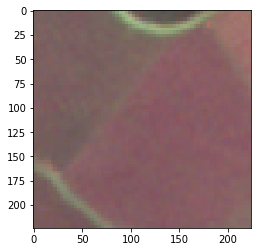

In [9]:
class_index = 0   # 0, 1, 2 or 3
img_index = 46 # 0 to max_img_index

Classes_Vet = [Class1_indexes, Class2_indexes, Class3_indexes, Class4_indexes]
max_img_index = np.array(Classes_Vet[class_index]).size

img_array = X[Classes_Vet[class_index]][img_index]

plt.imshow(img_array)
img_array=img_array.reshape((1,224,224,3))

In [10]:
LastLayer

18

# Step 1: Calculate all the features of each layer of each class for all images. Warning: it uses a lot of disk space!

In [11]:
import timeit
import math

Mean_Layer = []
cont = 0

for layer_id in [1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]:
    
    start = timeit.default_timer()
    print('Layer: ', layer_id)
    MeanVetClass = []
    
    for class_index in [0, 1, 2, 3]:
        max_img_index = np.array(Classes_Vet[class_index]).size
        
        layer_output_Vet = []
        #print('Number of Images: ', max_img_index)

        img_array = X[Classes_Vet[class_index]]
        #print("Layer Number:", layer_id)

        if(layer_id <= LastLayer ): # Base CNN model 
            LayerName = bottleneckModel.layers[layer_id].name
            #print("BottleNeck Network Layer:")
            #print(LayerName)

            model1=Model(inputs=bottleneckModel.input,outputs=bottleneckModel.get_layer(LayerName).get_output_at(0))
            H=model1.predict(img_array);


        else: # Complete model (Base CNN model + CNN model)
            LayerName = bottleneckModel.layers[LastLayer].name
            LayerName_trainable = loaded_model.layers[layer_id-LastLayer-1].name
            #print("BottleNeck Network Layer:", LayerName )
            #print("Trainable Network Layer:", LayerName_trainable)

            model1=Model(inputs=bottleneckModel.input,outputs=bottleneckModel.get_layer(LayerName).get_output_at(0))
            H=model1.predict(img_array);

            model2=Model(inputs=loaded_model.input,outputs=loaded_model.get_layer(LayerName_trainable).get_output_at(0))
            H = model2.predict(H);


        # Remove first dimension
        H_np = np.array(H,dtype=np.double)
        total_num_pixels = H_np.shape[1]*H_np.shape[2]*H_np.shape[3]
        layer_output_reshape = H_np.reshape(H_np.shape[0],total_num_pixels)

        SaveStrName = 'Layer_' + str(layer_id) + '_' + 'Class_' + str(class_index) + '.npy'

        np.save(SaveStrName, layer_output_reshape)



        #print("Calculating the Class Mean Vector for Class: ", class_index)
        cont+=1
        print("Progress: ", str(math.trunc((cont/(13*4))*10000)/100) + ' %')
        
    stop = timeit.default_timer()
    print('Inference Time [s]: ', math.trunc((stop - start)*100)/100)  

Layer:  1
Progress:  1.92 %
Progress:  3.84 %
Progress:  5.76 %
Progress:  7.69 %
Inference Time [s]:  127.41
Layer:  2
Progress:  9.61 %
Progress:  11.53 %
Progress:  13.46 %
Progress:  15.38 %
Inference Time [s]:  674.64
Layer:  4
Progress:  17.3 %
Progress:  19.23 %
Progress:  21.15 %
Progress:  23.07 %
Inference Time [s]:  28.13
Layer:  5
Progress:  25.0 %
Progress:  26.92 %
Progress:  28.84 %
Progress:  30.76 %
Inference Time [s]:  35.96
Layer:  7
Progress:  32.69 %
Progress:  34.61 %
Progress:  36.53 %
Progress:  38.46 %
Inference Time [s]:  13.71
Layer:  8
Progress:  40.38 %
Progress:  42.3 %
Progress:  44.23 %
Progress:  46.15 %
Inference Time [s]:  21.26
Layer:  9
Progress:  48.07 %
Progress:  50.0 %
Progress:  51.92 %
Progress:  53.84 %
Inference Time [s]:  18.78
Layer:  11
Progress:  55.76 %
Progress:  57.69 %
Progress:  59.61 %
Progress:  61.53 %
Inference Time [s]:  9.73
Layer:  12
Progress:  63.46 %
Progress:  65.38 %
Progress:  67.3 %
Progress:  69.23 %
Inference Time [s

# Step 2: Calculate the mean and standard deviation of all the features of each layer of each class for all images. Warning: it uses a lot of RAM!

In [12]:
Mean_Layer = []

for layer_id in [1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]:
    
    MeanVetClass = []
    layer_output_Vet = [] 
    
    for class_index in [0, 1, 2, 3]:
        LoadStrName = 'Layer_' + str(layer_id) +   '_'+ 'Class_' + str(class_index) + '.npy'
        print(LoadStrName, '\n')
        TempLoad = np.load(LoadStrName)
        print("Class Features of All Images in that Class: \n",TempLoad.shape)
        layer_output_Vet_Mean = TempLoad.mean(axis=0)
        print("Mean of the Features of All Images in that Class: \n", layer_output_Vet_Mean.shape)
        layer_output_Vet.append(layer_output_Vet_Mean) # Uses lots of memory!
        print("Appending Classes Mean for that Layer: \n", np.array(layer_output_Vet).shape)
        del TempLoad
        print('\n')
        
    layer_output_Vet = np.array(layer_output_Vet)
    Std_Layer = layer_output_Vet.std(axis=0)       
    print("Std between the Mean of all Classes individually for that Layer: \n", Std_Layer.shape)
    Mean_Layer.append(Std_Layer.mean())
    print("Appending the Mean of the previoius Std for each Layer: \n",  np.array(Mean_Layer).shape )
    
    

Layer_1_Class_0.npy 

Class Features of All Images in that Class: 
 (47, 3211264)
Mean of the Features of All Images in that Class: 
 (3211264,)
Appending Classes Mean for that Layer: 
 (1, 3211264)


Layer_1_Class_1.npy 

Class Features of All Images in that Class: 
 (962, 3211264)
Mean of the Features of All Images in that Class: 
 (3211264,)
Appending Classes Mean for that Layer: 
 (2, 3211264)


Layer_1_Class_2.npy 

Class Features of All Images in that Class: 
 (183, 3211264)
Mean of the Features of All Images in that Class: 
 (3211264,)
Appending Classes Mean for that Layer: 
 (3, 3211264)


Layer_1_Class_3.npy 

Class Features of All Images in that Class: 
 (111, 3211264)
Mean of the Features of All Images in that Class: 
 (3211264,)
Appending Classes Mean for that Layer: 
 (4, 3211264)


Std between the Mean of all Classes individually for that Layer: 
 (3211264,)
Appending the Mean of the previoius Std for each Layer: 
 (1,)
Layer_2_Class_0.npy 

Class Features of All Images i

# Show statistical results for each layer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [15]:
Mean_Layer_For_Plot = np.load(outfile)
layers_array = ('1','2','3','4','5','6','7', '8','9','10','11','12','13')
layers_x = list(range(0,len(Mean_Layer_For_Plot)))

In [ ]:
def BarPlotter(layers_x, Mean_Layer_For_Plot):
    
    layers_array = ('1','2','3','4','5','6','7', '8','9','10','11','12','13')
    plt.figure(figsize=(10,6))
    plt.bar(layers_x, Mean_Layer_For_Plot, align='center', alpha=0.6)
    plt.plot(layers_x,Mean_Layer_For_Plot,'b')
    plt.xticks(layers_x, layers_array)
    plt.ylabel('Standard Deviation')
    plt.xlabel('Convolutional Layer')
    plt.rc('grid', linestyle="dotted", color='black')
    axes = plt.gca()
    axes.set_ylim([0,0.28])
    plt.grid()
    plt.show()

In [ ]:
outfile18 = 'Mean_Layer_' + str(18) + '.npy'
outfile14 = 'Mean_Layer_' + str(14) + '.npy'
outfile10 = 'Mean_Layer_' + str(10) + '.npy'
Mean_Layer_For_Plot18 = np.load(outfile18)
Mean_Layer_For_Plot14 = np.load(outfile14)
Mean_Layer_For_Plot10 = np.load(outfile10)
layers_x = list(range(0,len(Mean_Layer_For_Plot18)))

BarPlotter(layers_x, Mean_Layer_For_Plot18)
BarPlotter(layers_x, Mean_Layer_For_Plot14)
BarPlotter(layers_x, Mean_Layer_For_Plot10)